Processing Coil20 dataset
Parameter setting: max iter(100), tol(0.0001), svd_e(False), step(None, 0.5), init(rand)
Generating initialization matrix, seed: 1, svd efficient: False
Initialized (Time cost: 0.864811897277832)s


Processing SPCA ACC: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]   

                   AC  n_iter      Time        Ta        Tb      Tacc
SPCA VP      0.935185     100  1.308537  0.191838  0.073254  0.000000
SPCA Newton  0.983796      25  0.335048  0.047901  0.003009  0.000000
SPCA ACC     0.983796      17  0.266306  0.033378  0.003006  0.006011


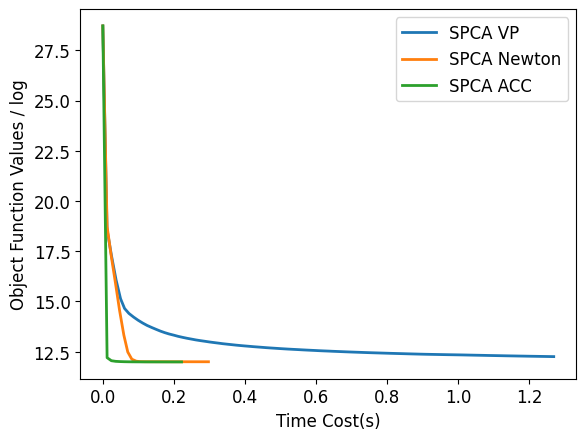

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils.parameters import Params
from utils.data_util import get_dataset_name_list, get_dataset_info
from utils.method_util import get_method_name_list, init_ab, classify_proc
from utils.plot_util import plot_lines
import os
import warnings
warnings.filterwarnings('ignore')

D_COIL20, D_DIGITS, D_USPS, D_OLI, D_YALE, D_MNIST, D_BASEHOCK, D_PCMAC, D_RELATHE = get_dataset_name_list()
S_SPCA_VP, S_SPCA_N, S_SPCA_ACC = get_method_name_list()

pd.set_option('display.max_columns', None)


def get_method_dict(n_comp, init='svd', alpha=1e-3, max_iter=100, tol=1e-4, svd_e=False):
    """
    Generate a dictionary of algorithm parameters for the specified settings.

    Args:
        n_comp (int): Number of components to be computed.
        init (str, optional): Initialization method. Defaults to 'svd'.
        max_iter (int, optional): Maximum number of iterations. Defaults to 100.
        tol (float, optional): Tolerance for convergence. Defaults to 1e-3.
        svd_e (bool, optional): Whether to use effective SVD (for large dataset) in initialization. Defaults to False.

    Returns:
        dict: A dictionary containing the parameter settings for each algorithm.
    """
    step1, step2 = None, 0.5
    """
    If step1 is set to None, the algorithm will automatically determine the step size during runtime based on the eigenvalues of the data matrix.
    When manually specifying step1, it is important to avoid using large step sizes to prevent the SPCA_VP algorithm from diverging. 
    As discussed in our paper, values between 0.1 and 0.5 are generally suitable for step2.
    """
    print(f"Parameter setting: max iter({max_iter}), tol({tol}), svd_e({svd_e}), step({step1}, {step2}), init({init})")
    ab_init = init_ab(data=data, n_comp=n_comp, method=init, seed=global_seed, svd_e=svd_e)
    p_dict = {
        S_SPCA_VP: Params(alpha=alpha, max_iter=max_iter, step=step1, init=ab_init,
                          tol=tol, svd_e=svd_e, newton=False),
        S_SPCA_N: Params(alpha=alpha, max_iter=max_iter, step=step2, newton=True,
                         init=ab_init, tol=tol, svd_e=svd_e),
        S_SPCA_ACC: Params(alpha=alpha, max_iter=max_iter, step=step2, acc_step=step2, newton=True,
                           acc=2, init=ab_init, tol=tol, svd_e=svd_e),
    }
    return p_dict


def ret_comp_res(data, label, setting):
    """
    Perform classify experiments using algorithms with specified parameter configurations
    and return the corresponding experimental results.

    Args:
        data (np.ndarray): Input data matrix.
        label (list): True labels for the data.
        setting (dict): Dictionary containing the parameter settings.

    Returns:
        pd.DataFrame: A DataFrame containing the experimental results for each algorithm.

    """
    len_obj_list, obj_list, res_list, total_time_list, total_obj_list = 0, [], [], [], []
    init, max_iter, tol, svd_e = setting['init'], setting['max_iter'], setting['tol'], setting['svd_e']
    p_dict = get_method_dict(n_comp=n_comp, init=init, max_iter=max_iter, tol=tol, svd_e=svd_e)
    tqdm_iter = tqdm(p_dict.items())
    for m_i, p_i in tqdm_iter:
        tqdm_iter.set_description(f'Processing {m_i}')
        metric, obj, p_time, t, ta, tb, tacc = classify_proc(data=data, d_label=label, p_method=m_i, params=p_i)
        total_time_list.append(np.cumsum(t))
        total_obj_list.append(obj_list)
        metric.extend([len(obj) - 1, p_time, np.sum(ta), np.sum(tb), np.sum(tacc)])
        if len(obj) > len_obj_list:
            len_obj_list = len(obj)
        obj_list.append(obj)
        res_list.append(metric)
    res = pd.DataFrame(res_list, index=p_dict.keys(), columns=['AC', 'n_iter', 'Time', 'Ta', 'Tb', 'Tacc'])
    print(res)
    data_plot = []
    for i, p_key in enumerate(p_dict.keys()):
        data_plot.append([p_key, (total_time_list[i], np.log(obj_list[i]))])
    plot_lines(data_plot, label_x='Time Cost(s)', label_y='Object Function Values / log')


setting_dict = {
    'init': 'rand',
    'max_iter': 100,
    'tol': 1e-4,
    'svd_e': False,
}

DATASET_PATH = os.path.join(os.getcwd(), 'data') 
data_name = D_COIL20  # change data_name to change dataset
data, label, n_comp = get_dataset_info(dir=DATASET_PATH, name=data_name)
global_seed = 1
print(f"Processing {data_name} dataset")
ret_comp_res(data, label, setting_dict)
